In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from ds import Emotion

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "minGPT")))
from mingpt.model import GPT
from mingpt.bpe import BPETokenizer
from utils import CollateForTraining, TrainingCollation

/homes/cdt21/aleks/understanding-prefixing/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare the data

In [2]:
# You need to download this file from the provided Google Drive link
# We have combined the prefixes learned from running train_prefixes.sh into a single tensor that is this file
prefixes = torch.load('longer_prefixes.pt')
n_prefixes, n_layers, prefix_size, n_dim = prefixes.shape
print(f"Loaded {n_prefixes} prefixes of length {prefix_size} with {n_dim} dimensions")

Loaded 20 prefixes of length 10 with 768 dimensions


In [9]:
# setup the model, this uses GPT-2 with the minGPT implementation
torch.set_default_tensor_type(torch.cuda.FloatTensor)

model = GPT.from_pretrained("gpt2")
add_spaces = True

model.cuda()
model.eval()

tokenizer = BPETokenizer()
tokenizer_encoder = lambda x: tokenizer.encoder.encode(x)
tokenizer_decoder = lambda x: tokenizer.encoder.decode(x)
eos_tokens = tokenizer_encoder('<|endoftext|>')
max_seq_len = 128
max_batch_size = 32
prefix_str = " ".join(["P"] * prefix_size)

number of parameters: 138.65M


In [10]:
# Prepare the data
ds = Emotion("test")
x_introduction, y_introduction = (ds.x_introduction, ds.y_introduction)
collate_fn = CollateForTraining(
    tokenizer_encoder,
    tokenizer_decoder,
    x_introduction=x_introduction,
    y_introduction=y_introduction,
    max_seq_len=max_seq_len - prefix_size,
    eos_tokens=eos_tokens,
    add_spaces=add_spaces
)

dl_test = DataLoader(
    ds,
    batch_size=max_batch_size,
    shuffle=False,
    num_workers=8,
    drop_last=True,
    collate_fn=collate_fn,
    generator=torch.Generator(device="cuda"),
) 

Found cached dataset emotion (/homes/cdt21/aleks/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


In [12]:
# extract the attention patterns, we only care about the last attention of the last user (x) token as this determines the class
attentions_over_prefix = torch.zeros((n_prefixes, n_layers, prefix_size, len(dl_test)*max_batch_size))

for prefix_idx in range(n_prefixes):
    pbar = tqdm.tqdm(
        enumerate(dl_test),
        desc=f"Testing prefix {prefix_idx+1}",
        total=len(dl_test),
    )
    for b_idx, b in pbar:
        b: TrainingCollation
        bsz = b.all_tokens.size(0)
        
        inputs = [
            f"{prefix_str} {x_introduction} {x} {y_introduction}" for x in b.x_str
        ]

        with torch.no_grad(), torch.autocast(
            device_type="cuda", dtype=torch.float16
        ):
            results = []
            for input_idx, input in enumerate(inputs):
                record = []
                result = model.generate(
                    torch.tensor(tokenizer_encoder(input), dtype=torch.long).unsqueeze(0),
                    max_new_tokens=1,
                    do_sample=False,
                    prefixes=prefixes[prefix_idx],
                    activations_record=record,
                )

                layer_ctr = 0
                for rec_type, rec_tensor in record:
                    if rec_type == "attention":
                        attentions_over_prefix[prefix_idx, layer_ctr, :, b_idx*bsz+input_idx] = rec_tensor[0, layer_ctr, -1, :prefix_size]
                        layer_ctr += 1

    pbar.close()
                        
# Normalize so that the attention over the prefix sums to 1
attentions_over_prefix = attentions_over_prefix / attentions_over_prefix.sum(dim=2, keepdim=True)

Testing prefix 20: 100%|██████████| 62/62 [00:06<00:00,  9.39it/s]


In [19]:
# convert to dataframe for easier analysis

# Initialize lists to hold data
prefix_list = []
layer_list = []
data_list = []

# Populate lists from the tensor
for prefix in range(n_prefixes):
    for layer in range(n_layers):
        for sample in range(attentions_over_prefix.size(-1)):
            prefix_list.append(prefix)
            layer_list.append(layer)
            data_list.append(attentions_over_prefix[prefix, layer, :, sample].tolist())

# Create DataFrame
df = pd.DataFrame(data_list, columns=[f'prefix_pos_{i}' for i in range(prefix_size)])
df['prefix'] = prefix_list
df['layer'] = layer_list

# Reorder columns
df = df[['prefix', 'layer'] + [f'prefix_pos_{i}' for i in range(prefix_size)]]

df


,prefix,layer,prefix_pos_0,prefix_pos_1,prefix_pos_2,prefix_pos_3,prefix_pos_4,prefix_pos_5,prefix_pos_6,prefix_pos_7,prefix_pos_8,prefix_pos_9
0,0,0,0.005310,0.000982,0.002113,0.024606,0.001303,0.009788,0.917035,0.036472,0.001693,6.993767e-04
1,0,0,0.005703,0.000995,0.002234,0.024645,0.001288,0.010395,0.916712,0.035545,0.001746,7.362692e-04
2,0,0,0.004515,0.000882,0.001913,0.020473,0.001209,0.010355,0.928510,0.029964,0.001526,6.523587e-04
3,0,0,0.004547,0.000956,0.001707,0.022482,0.001217,0.011118,0.921131,0.034482,0.001703,6.567236e-04
4,0,0,0.005310,0.000982,0.002113,0.024606,0.001303,0.009787,0.917034,0.036472,0.001693,6.993766e-04
...,...,...,...,...,...,...,...,...,...,...,...,...
476155,19,11,0.002952,0.423797,0.000375,0.535730,0.001749,0.028337,0.006549,0.000084,0.000425,1.238718e-11
476156,19,11,0.003283,0.073556,0.000276,0.891301,0.008482,0.009064,0.013767,0.000149,0.000122,4.797977e-12
476157,19,11,0.005060,0.297529,0.000153,0.627413,0.005711,0.059046,0.004227,0.000075,0.000785,3.479548e-12
476158,19,11,0.006489,0.128321,0.000074,0.572851,0.000545,0.286365,0.004425,0.000072,0.000858,1.443196e-12


# Compute summary about the average spread of attention for each layer across the 20 prefixes and all samples

In [20]:
# Compute the gap between the 1st and 99th percentile for each prefix and prefix position for each layer

def compute_percentile_gap(series):
    p1 = np.percentile(series, 1)
    p99 = np.percentile(series, 99)
    return p99-p1

# Group by 'prefix' and 'layer' and apply the function to each column
percentile_gap_df = df.groupby(['prefix', 'layer']).agg({col: compute_percentile_gap for col in df.columns if col not in ['prefix', 'layer']})

# percentile_gap_df.mean(axis='columns')
# and now mean across prefixes (first row level, but not second)
percentile_gap_df.mean(axis='columns').groupby(['layer']).mean()

layer
0     0.016056
1     0.102104
2     0.174358
3     0.088431
4     0.076230
5     0.068907
6     0.079767
7     0.105598
8     0.162684
9     0.146836
10    0.155692
11    0.102223
dtype: float64

# Density plot for a single prefix and layer

<Axes: ylabel='Density'>

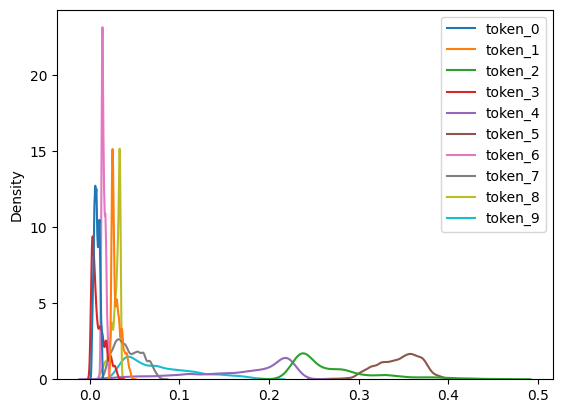

In [135]:
prefix_id = 0
layer_id = 1

plot_df = pd.DataFrame(attentions_over_prefix[prefix_id][layer_id].cpu().numpy().T, columns=[f"token_{i}" for i in range(prefix_size)])
# sns.histplot(data=plot_df, bins=30, kde=True, stat="density", alpha=0.5)
sns.kdeplot(data=plot_df, alpha=1, log_scale=(False,False), bw_adjust=0.75)

# Plot the attention ranges for all layers and all prefix positions for a single prefix and all test samples

In [23]:
# Compute the range of attention each prefix and prefix position sees for each layer

# Function to compute and format the 1st and 99th percentiles
def compute_percentiles(series):
    p1 = np.percentile(series, 1)
    p99 = np.percentile(series, 99)
    return f"{p1:.3f}—{p99:.3f}"

# Group by 'prefix' and 'layer' and apply the function to each column
percentile_df = df.groupby(['prefix', 'layer']).agg({col: compute_percentiles for col in df.columns if col not in ['prefix', 'layer']})

percentile_df

prefix_pos_0 prefix_pos_1 prefix_pos_2 prefix_pos_3 prefix_pos_4  \
prefix layer                                                                    
0      0      0.003—0.006  0.001—0.001  0.001—0.002  0.019—0.026  0.001—0.001   
       1      0.003—0.014  0.024—0.045  0.220—0.423  0.002—0.030  0.028—0.230   
       2      0.000—0.002  0.069—0.734  0.004—0.026  0.000—0.011  0.000—0.003   
       3      0.000—0.002  0.001—0.022  0.008—0.016  0.004—0.114  0.006—0.019   
       4      0.000—0.001  0.000—0.002  0.001—0.003  0.026—0.072  0.000—0.001   
...                   ...          ...          ...          ...          ...   
19     7      0.000—0.000  0.000—0.001  0.004—0.101  0.000—0.004  0.000—0.002   
       8      0.053—0.280  0.129—0.488  0.005—0.023  0.001—0.007  0.000—0.003   
       9      0.001—0.036  0.000—0.000  0.001—0.049  0.836—0.994  0.000—0.001   
       10     0.305—0.852  0.010—0.279  0.001—0.007  0.038—0.587  0.000—0.004   
       11     0.000—0.019  0.026—0.616  0.000—0.004  0.324—0.930  0.000—0.023   

             prefix_pos_5 prefix_pos_6 prefix_pos_7 prefix_pos_8 prefix_pos_9  
prefix layer                                                                   
0      0      0.009—0.012  0.912—0.939  0.024—0.038  0.001—0.002  0.001—0.001  
       1      0.287—0.390  0.012—0.020  0.018—0.074  0.013—0.035  0.030—0.178  
       2      0.094—0.805  0.075—0.249  0.001—0.039  0.000—0.014  0.000—0.012  
       3      0.004—0.017  0.001—0.002  0.001—0.004  0.448—0.738  0.219—0.413  
       4      0.003—0.009  0.001—0.003  0.907—0.956  0.001—0.004  0.003—0.012  
...                   ...          ...          ...          ...          ...  
19     7      0.409—0.981  0.012—0.497  0.000—0.000  0.001—0.023  0.000—0.013  
       8      0.121—0.445  0.061—0.306  0.009—0.087  0.015—0.217  0.003—0.021  
       9      0.000—0.002  0.000—0.000  0.000—0.008  0.000—0.002  0.004—0.073  
       10     0.013—0.123  0.000—0.000  0.000—0.032  0.008—0.136  0.000—0.001  
       11     0.005—0.276  0.000—0.035  0.000—0.000  0.000—0.002  0.000—0.000  

[240 rows x 10 columns]

/homes/cdt21/aleks/understanding-prefixing/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/homes/cdt21/aleks/understanding-prefixing/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/homes/cdt21/aleks/understanding-prefixing/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/homes/cdt21/aleks/understanding-prefixing/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout

<Figure size 640x480 with 0 Axes>

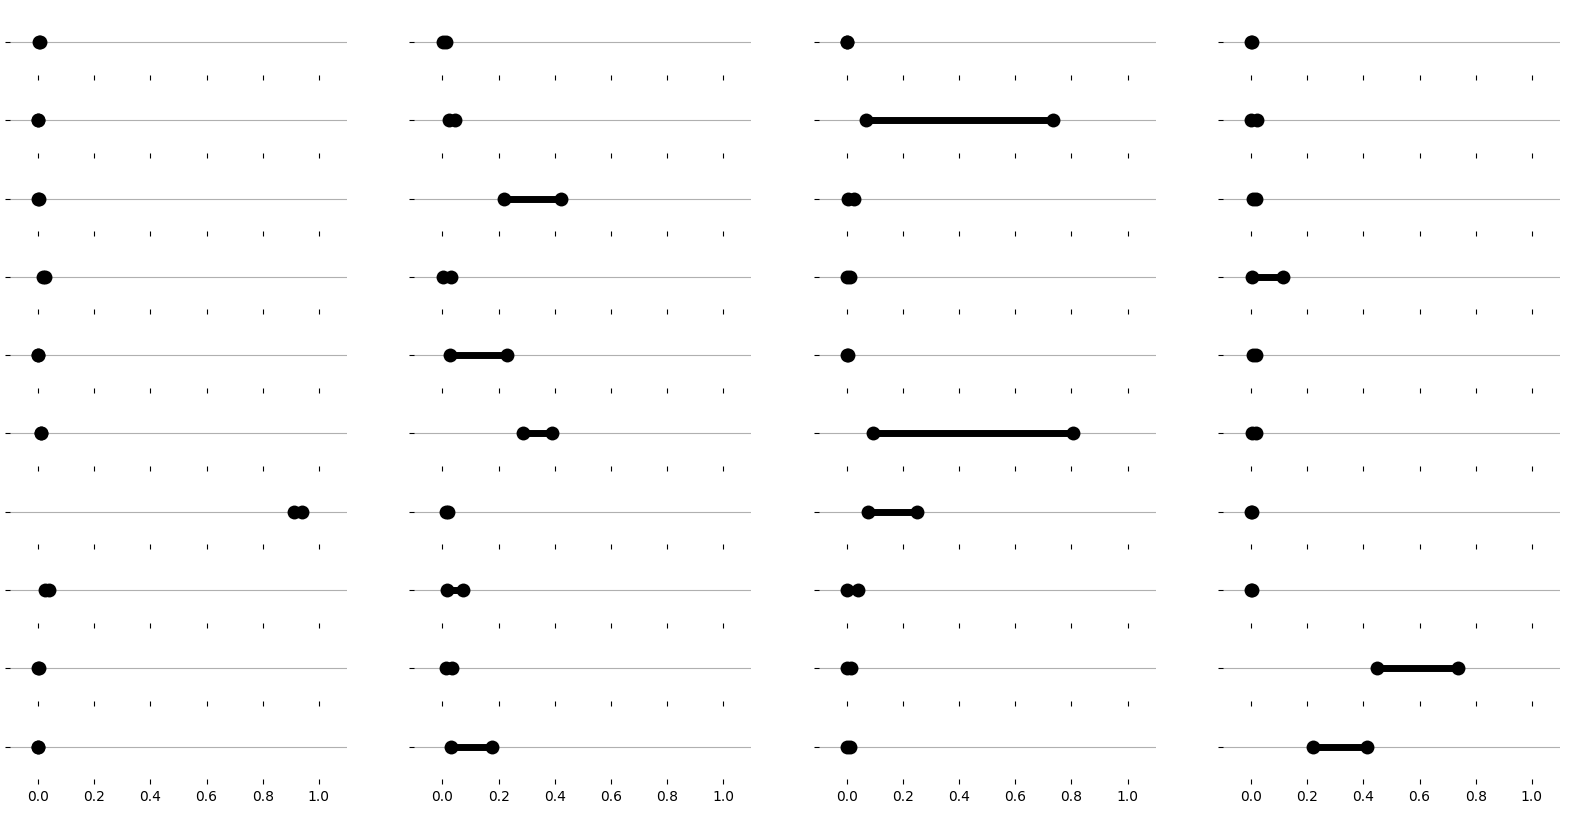

<Figure size 640x480 with 0 Axes>

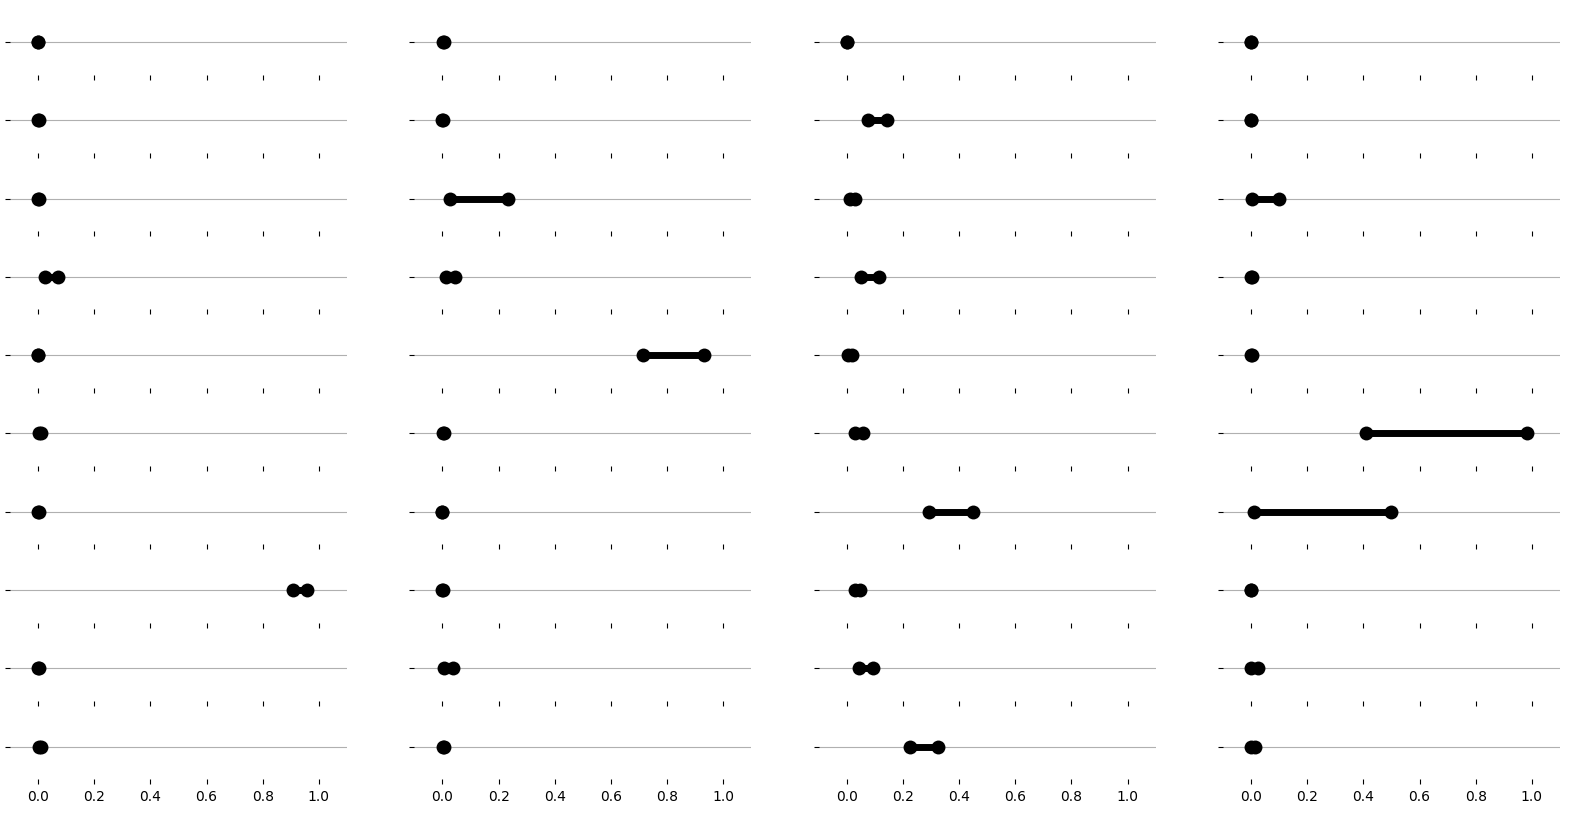

<Figure size 640x480 with 0 Axes>

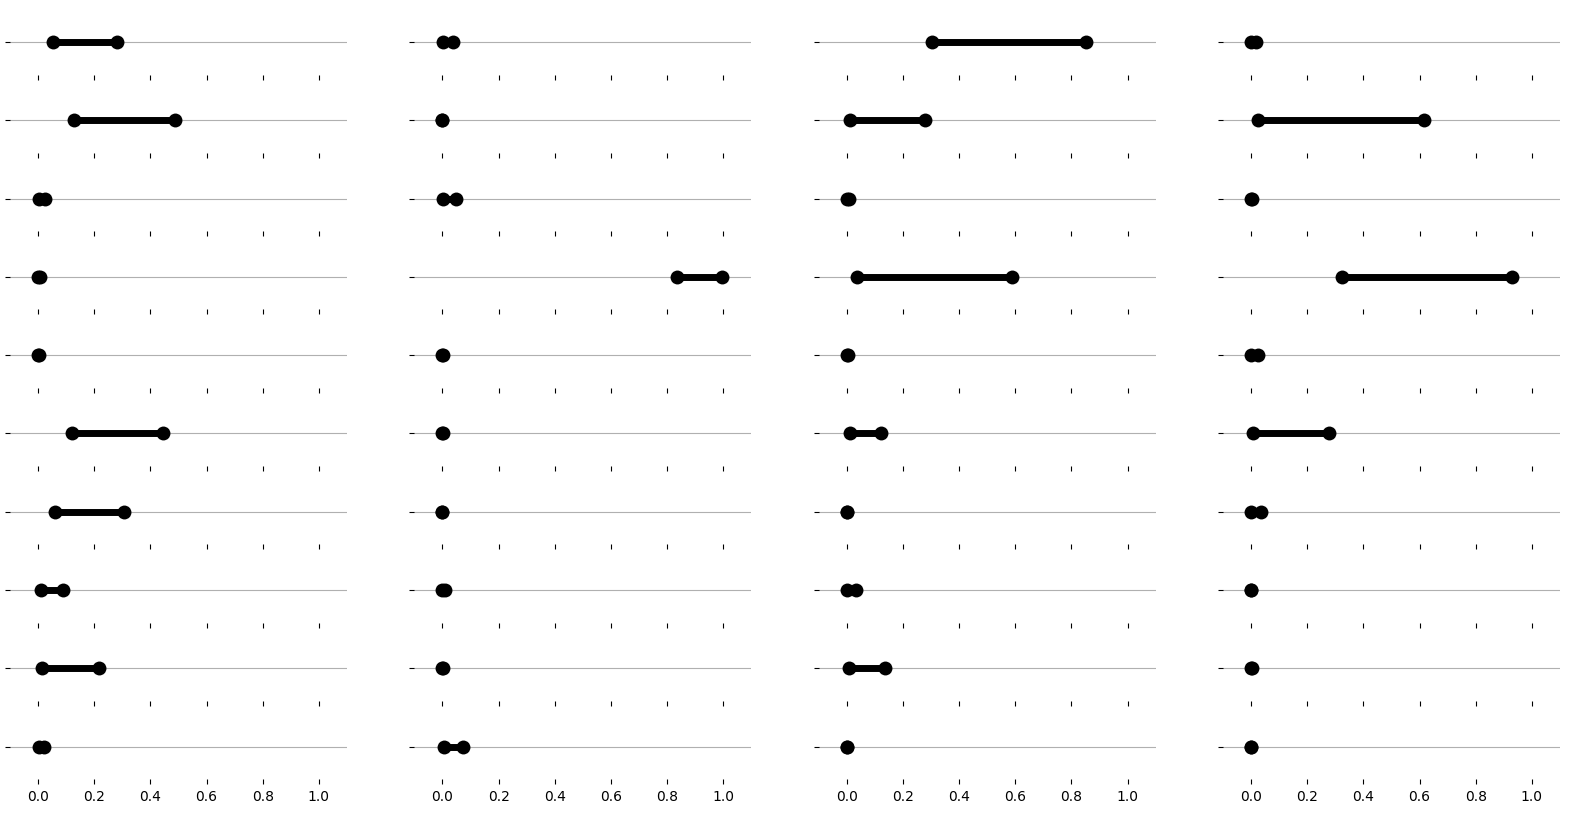

In [72]:
# Extract data for prefix=0 and plot
prefix_id = 0
subset_df = percentile_df.loc[prefix_id].reset_index()

# Transform the data to long format
melted_df = subset_df.melt(id_vars='layer', value_vars=[f'prefix_pos_{i}' for i in range(prefix_size)], var_name='column', value_name='range')

# Extract 1st and 99th percentiles into separate columns
melted_df['p1'] = melted_df['range'].apply(lambda x: float(x.split('—')[0]))
melted_df['p99'] = melted_df['range'].apply(lambda x: float(x.split('—')[1]))
# combine into a tuple
melted_df['range'] = melted_df.apply(lambda x: (x['p1'], x['p99']), axis=1)

# create a column with all the values from df for this prefix_id and for any given layer and position
melted_df['all_values'] = melted_df.apply(lambda x: df[(df.prefix == prefix_id) & (df.layer == x.layer)][x.column].values, axis=1)

# THIS WILL PLOT THE PERCENTILES:

# now pivot so that each layer has its own column for p1 and p99, with the layers being the top indix
melted_df = melted_df.pivot(index='column', columns='layer', values=['range']).T
# drop the top column index

# now melt everythign so that we have one column with layer, one column with the name of the column and one column with the range
melted_df = melted_df.reset_index().melt(id_vars='layer', value_vars=[f'prefix_pos_{i}' for i in range(prefix_size)], var_name='column', value_name='range')

def stripplot(*args, **kwargs):
    l, u = args[0].iloc[0]
    sns.stripplot([l,u], size=10, orient="h", jitter=False,
      linewidth=0, color="k")
    plt.plot([l, u], [0,0], color="k", lw=5)

for part in range(3):
    plt.figure()
    g = sns.FacetGrid(melted_df[(part*4 <= melted_df.layer) & (melted_df.layer < (part+1)*4)],
                    row="column", col="layer",
                    height=1, aspect=5, despine=True,margin_titles=True,sharey=True,sharex=True)
    g.map(stripplot, "range")
    g.set(xlim=(-0.1, 1.1), xlabel="", ylabel="")
    g.set_axis_labels(None, None)
    g.set_titles(col_template="", row_template="")

    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    sns.despine(left=True, bottom=True)
    plt.savefig(f'prefixes_{part}.pdf', bbox_inches='tight')

# THIS WILL PLOT THE DISTRIBUTIONS:

# melted_df = melted_df.pivot(index='column', columns='layer', values=['all_values']).T
# melted_df = melted_df.reset_index().melt(id_vars='layer', value_vars=[f'prefix_pos_{i}' for i in range(prefix_size)], var_name='column', value_name='all_values')
# print(melted_df)
# def distplot(*args, **kwargs):
#     all_values = args[0].iloc[0]
#     sns.kdeplot( all_values,
#       bw_adjust=1,
#       fill=True, alpha=1, linewidth=1.5, log_scale=(False,True))
#     # sns.kdeplot(all_values, clip_on=False, color="w", lw=2, bw_adjust=.5)

# for part in range(3):
#     plt.figure()
#     g = sns.FacetGrid(melted_df[(part*4 <= melted_df.layer) & (melted_df.layer < (part+1)*4)],
#                     row="column", col="layer",
#                     height=1, aspect=5, despine=True,margin_titles=True,sharey=True,sharex=True)
#     g.map(distplot, "all_values")
#     g.set(xlim=(-0.1, 1.1), xlabel="", ylabel="")
#     g.set_axis_labels(None, None)
#     g.set_titles(col_template="", row_template="")

#     for ax in g.axes.flat:
#         ax.xaxis.grid(False)
#         ax.yaxis.grid(True)
#         ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_visible(False)

#     sns.despine(left=True, bottom=True)
#     plt.savefig(f'prefixes_{part}.pdf', bbox_inches='tight')

<Axes: ylabel='Density'>

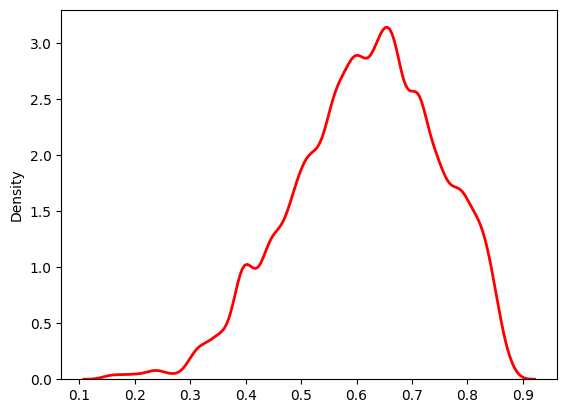

In [66]:
sns.kdeplot(melted_df[(melted_df.layer == 10) & (melted_df.column == 'prefix_pos_0')]['all_values'].iloc[0], color="r", lw=2, bw_adjust=.5)

In [54]:
melted_df[(melted_df.layer == 0) & (melted_df.column == 'prefix_pos_0')]['all_values'].iloc[0].shape

(1984,)